# Operating the Stacked Auto Encoder Denoising Model

This module operates(trains and tests) autoencoder neural network.
The neural network architecture is simply constructed, and follows the DNN Pixel Classifier model, with the the last layers removed.

+ The main idea is to create a stacked, densifying pyramidal set of representations, of the _input patch_.
With the added step that the representations act as **denoising** representations of the input



This **denoising** principle is better explained in Section 3 of <sup>[[vincent2010]](http://www.jmlr.org/papers/volume11/vincent10a/vincent10a.pdf)</sup>.

![sdae basic architecture](https://i.imgur.com/VdfvPsO.png)
In this image:
+ **x = corrected(true) image patch**
+ **x<sup>~</sup> = interim/(considered stochastic, damaged) patch version**.

The autoencoding neural network <b><i>f<sub>&theta;</sub> </i></b> first creates hierarchical representations 
<b><i>y </i></b> , of the <b><i>interim(stochastic) - x<sup>~</sup> patch.</i></b> Then from <b><i>y </i></b>, the decoder <b><i> g<sub>&theta;'</sub> <b><i> creates representation <b><i>z</i></b> patch, which is compared to the <b><i>x - corrected(true) patch</i></b>. The loss is then calculated using a Loss Cross Entropy Function  <b><i> L<sub>&Eta;</sub>(x,z) </i></b>

The original paper supposes that the **corrupting process** <b><i> x˜ ∼ q<sub>D</sub>(x˜|x) </i></b> can be:
+ Gaussian noise;
+ Masking noise;
+ Salt/Pepper noise.



*(Our motivation was viewing the **interim version** as a **noisy,corrupted version** of the **corrected** image patch.)*

------




Using this notebook, an AEN model can be:
 1. Trained from a lmdb training database, with **specific** train parameters;
 2. Tested by visualising an already trained SDAE neural network.


____

## Importing Modules

+ The main computational libraries are again [Keras](https://keras.io/), and [Tensorflow](https://www.tensorflow.org/).



In [1]:
%matplotlib inline
import time

import os
import sys
import time
from os.path import join

import cv2
import keras.backend.tensorflow_backend as KTF
import lmdb
import numpy as np
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.models import load_model
import matplotlib.pyplot as plt

sys.path.append("../..")

import dnn_segmentation.net.utils as net_utils


from dnn_segmentation.net.utils.models import  get_autoencoded
from dnn_segmentation.net.utils.train_h import iterate_indef, \
    get_session, make_split_map, draw_autoenc_smaller,draw_someoutput

    
print('Every import is succesful !')

Using TensorFlow backend.


Every import is succesful !


## Setting Training Parameters


These parameters deals with setting up training parameters, of a new AEN network.

**Skip if just Visualising.**

The parameters are:
+ train/visualise **boolean** setup flag;
+ database,model,logging locations;
+ Image patching parameters;
+ new AEN parameters:
   1. optimizer,
   2. loss function,
   3. batch size,
   4. train epoch number,
   5. other config parameters.



In [2]:
# MAIN CONFIG FLAG, False if new training
justDraw=True


KTF.set_session(get_session(0.8))

train_lmdb=r'#####\train_db'
val_lmdb=r'#########\val_db'

model_locs=r'../test_data'
log_loc=r'../test_data/logs'
img_w,img_h=45,45
big_img_size=2048

# optimizer = SGD(lr=0.0001, decay=0.0005,
# momentum=0.9, nesterov=True)
optimizer='adadelta'


loss_func='categorical_crossentropy'

batch_size=500
epoch_count=1
split_patches=True   #True for normal autoenc
do_single_map=False    #False for normal autoenc

np.random.seed(None)
quick_str=''.join(map(chr,np.random.randint(97,97+26,(4,))) )

weights_prepend='weights_autoenc_'+quick_str


##  Train Callback Parameters



This block deals with the possible callback functions called during **training**.

An additional history callback can be activated, which saves the training AEN (validation loss) curve.


In [3]:

# hist_loc=r'!!!!!'
# log_losses=net_utils.LogLossesCallback(123500//batch_size,1,model_id=quick_str,save_loc=hist_loc)


save_model_call=ModelCheckpoint(os.path.join(model_locs,weights_prepend+'.{epoch:02d}-{val_loss:.4f}.hdf5'),
                                verbose=1,monitor='val_loss'
                                )
earlystop_call=EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, mode='auto')
tensor_call=TensorBoard(log_dir=log_loc, histogram_freq=3, write_graph=True, write_images=True)




all_calls=[save_model_call,earlystop_call,tensor_call,
#           log_losses
          ]


## Subsampling Visual Test Input

This next code block visualises specific patches from the Frontal Lobe ml dataset 1.

The main setup parameters are:

1. Just Draw, Config Flag,

  -> whether to execute new visualization;
2. location of new visualised patches location.

The other parameters can be changed with **other image data**, or other already **trained AEN models**.



(2048, 2048) (2048, 2048)
(None, 48, 48, 3)
(6, 48, 48) (162, 162) 0
convolution2d_1 (None, 48, 48, 80)
(9, 48, 48) (162, 162) 0
(9, 48, 48) (162, 162) 0
(9, 48, 48) (162, 162) 0
(9, 48, 48) (162, 162) 0
(9, 48, 48) (162, 162) 0
(9, 48, 48) (162, 162) 0
convolution2d_1 (None, 48, 48, 80)
(9, 48, 48) (162, 162) 0
(9, 48, 48) (162, 162) 0
(9, 48, 48) (162, 162) 0
(9, 48, 48) (162, 162) 0
(9, 48, 48) (162, 162) 0
(9, 48, 48) (162, 162) 0
convolution2d_1 (None, 48, 48, 80)
(9, 48, 48) (162, 162) 0
(9, 48, 48) (162, 162) 0
(9, 48, 48) (162, 162) 0
(9, 48, 48) (162, 162) 0
(9, 48, 48) (162, 162) 0
(9, 48, 48) (162, 162) 0
convolution2d_1 (None, 48, 48, 80)
(9, 48, 48) (162, 162) 0
(9, 48, 48) (162, 162) 0
(9, 48, 48) (162, 162) 0
(9, 48, 48) (162, 162) 0
(9, 48, 48) (162, 162) 0
(9, 48, 48) (162, 162) 0
convolution2d_1 (None, 48, 48, 80)
(9, 48, 48) (162, 162) 0
(9, 48, 48) (162, 162) 0
(9, 48, 48) (162, 162) 0
(9, 48, 48) (162, 162) 0
(9, 48, 48) (162, 162) 0
(9, 48, 48) (162, 162) 0
convol

SystemExit: Im am done with everything!!

/home/kiks/miniconda3/envs/tensorflow_fast/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2971: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


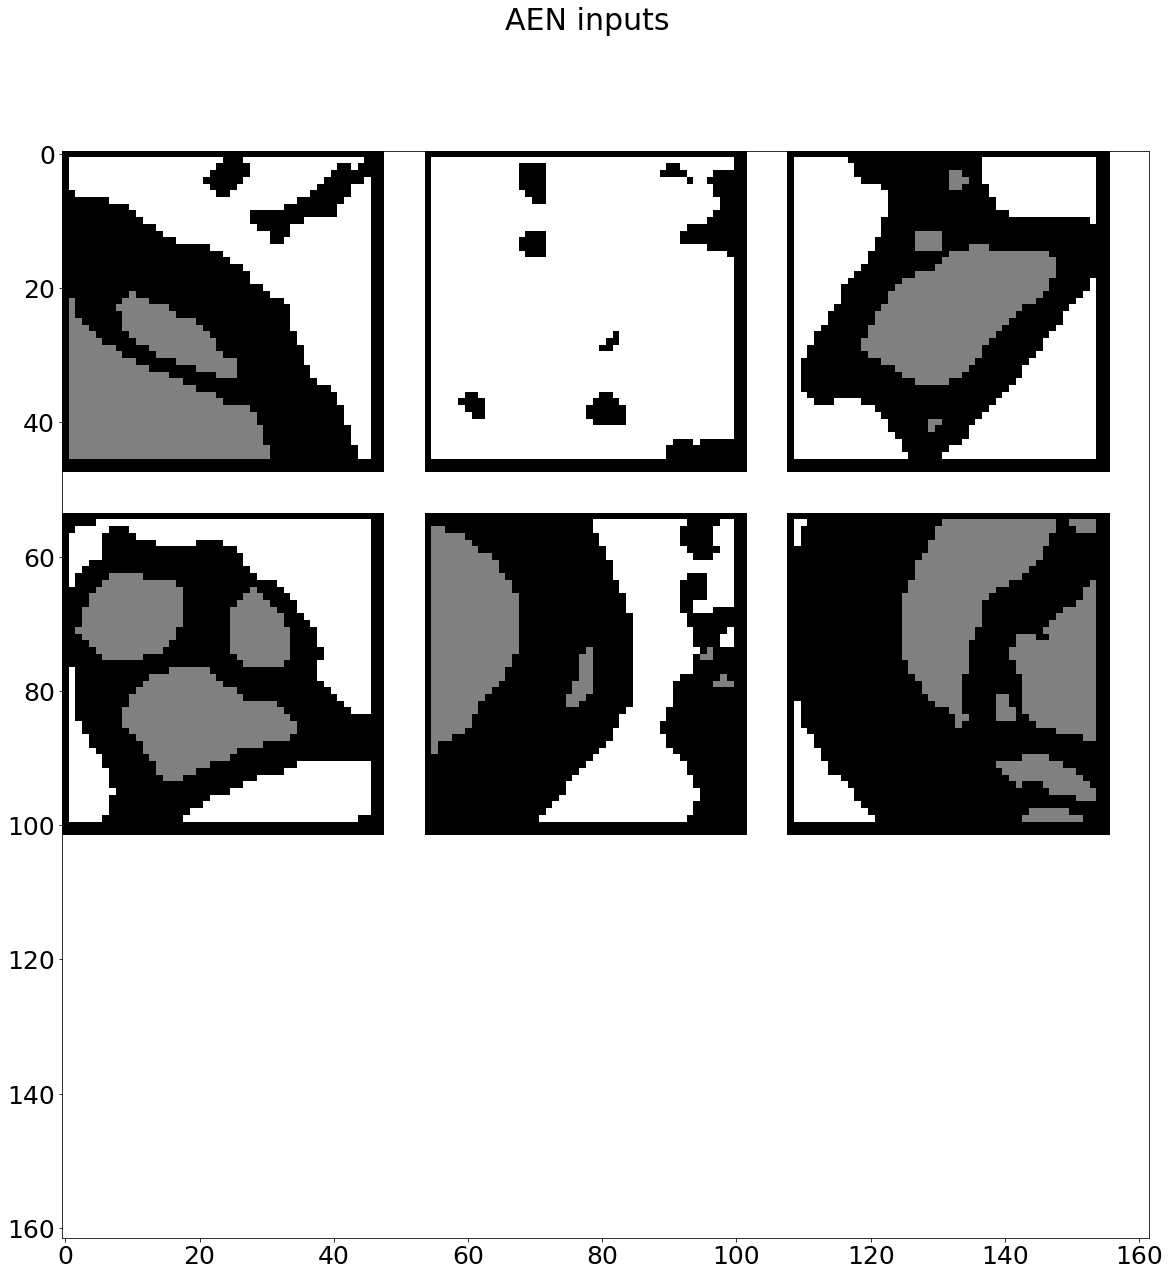

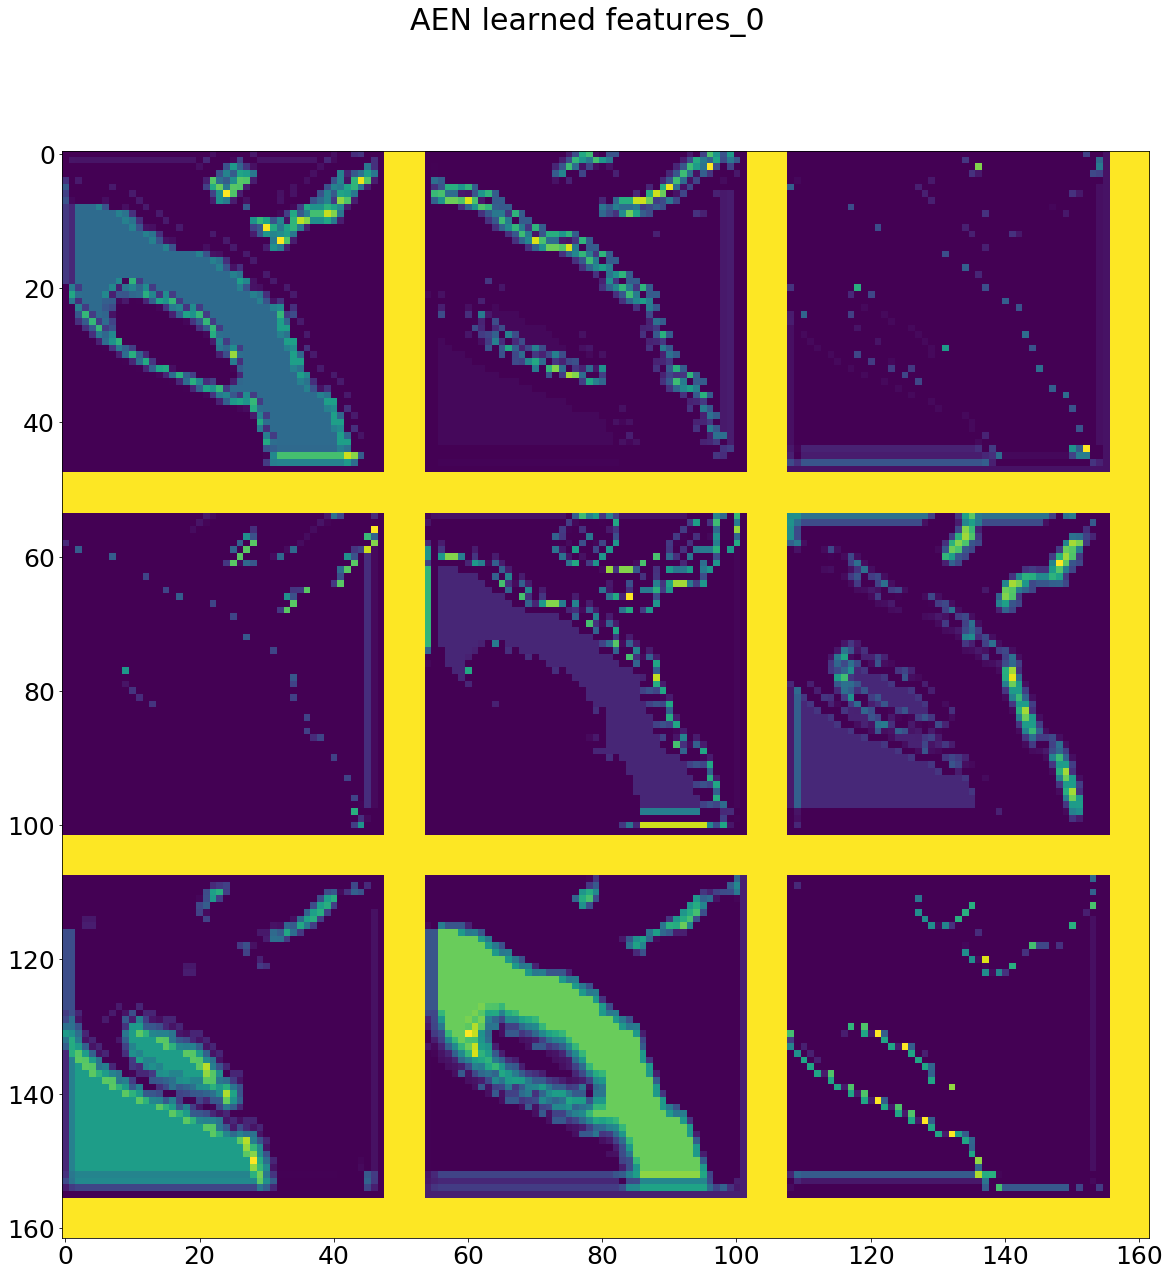

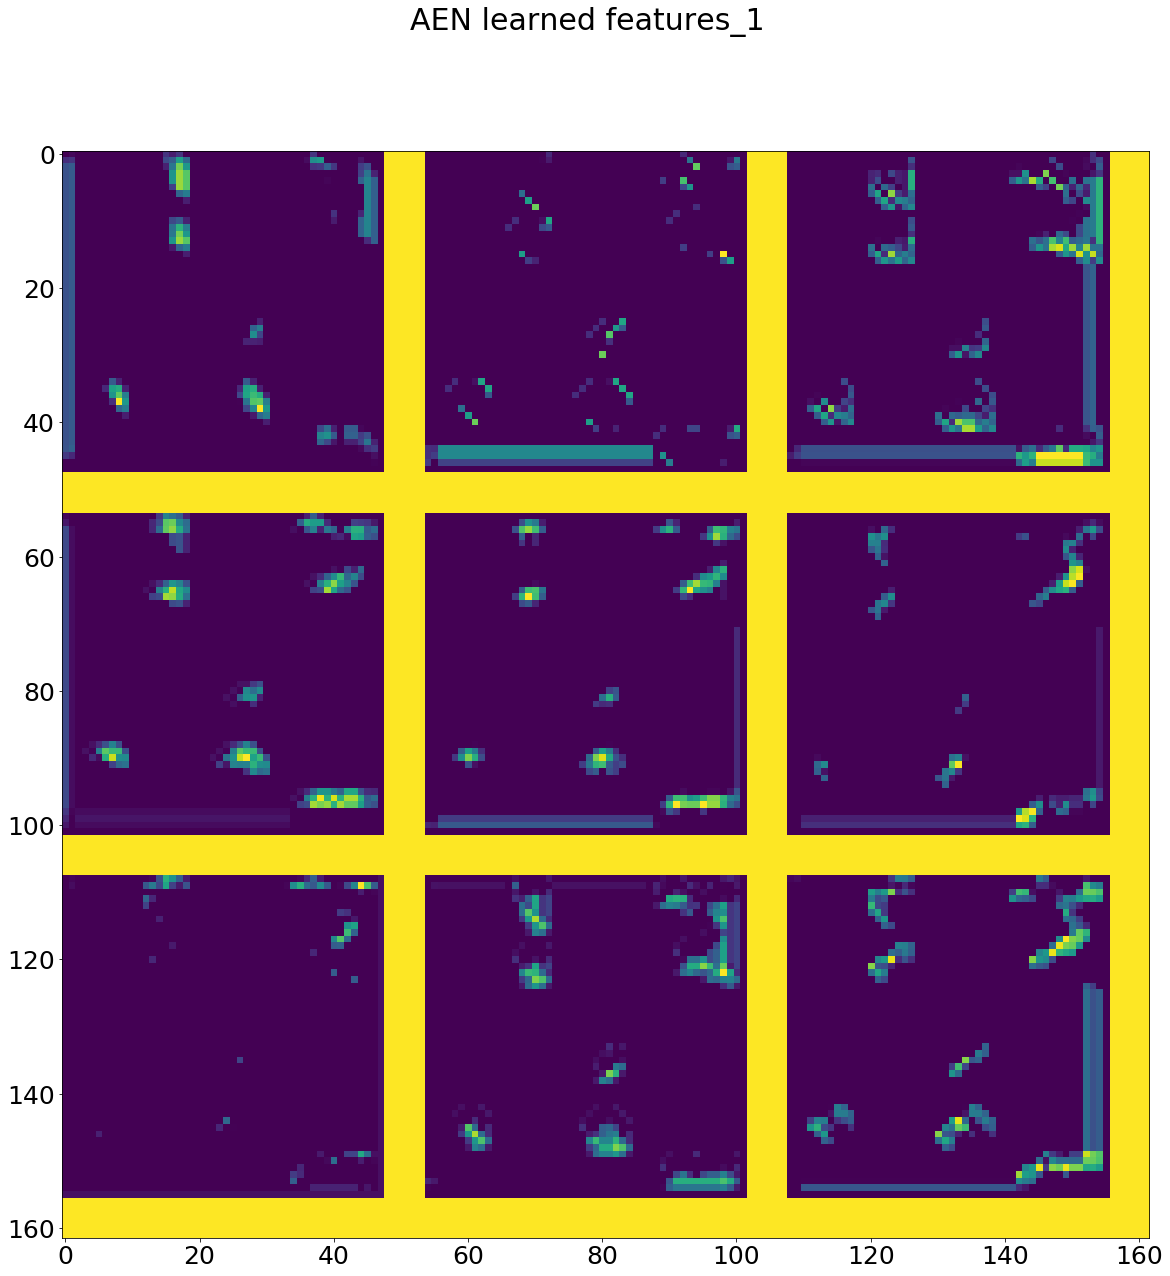

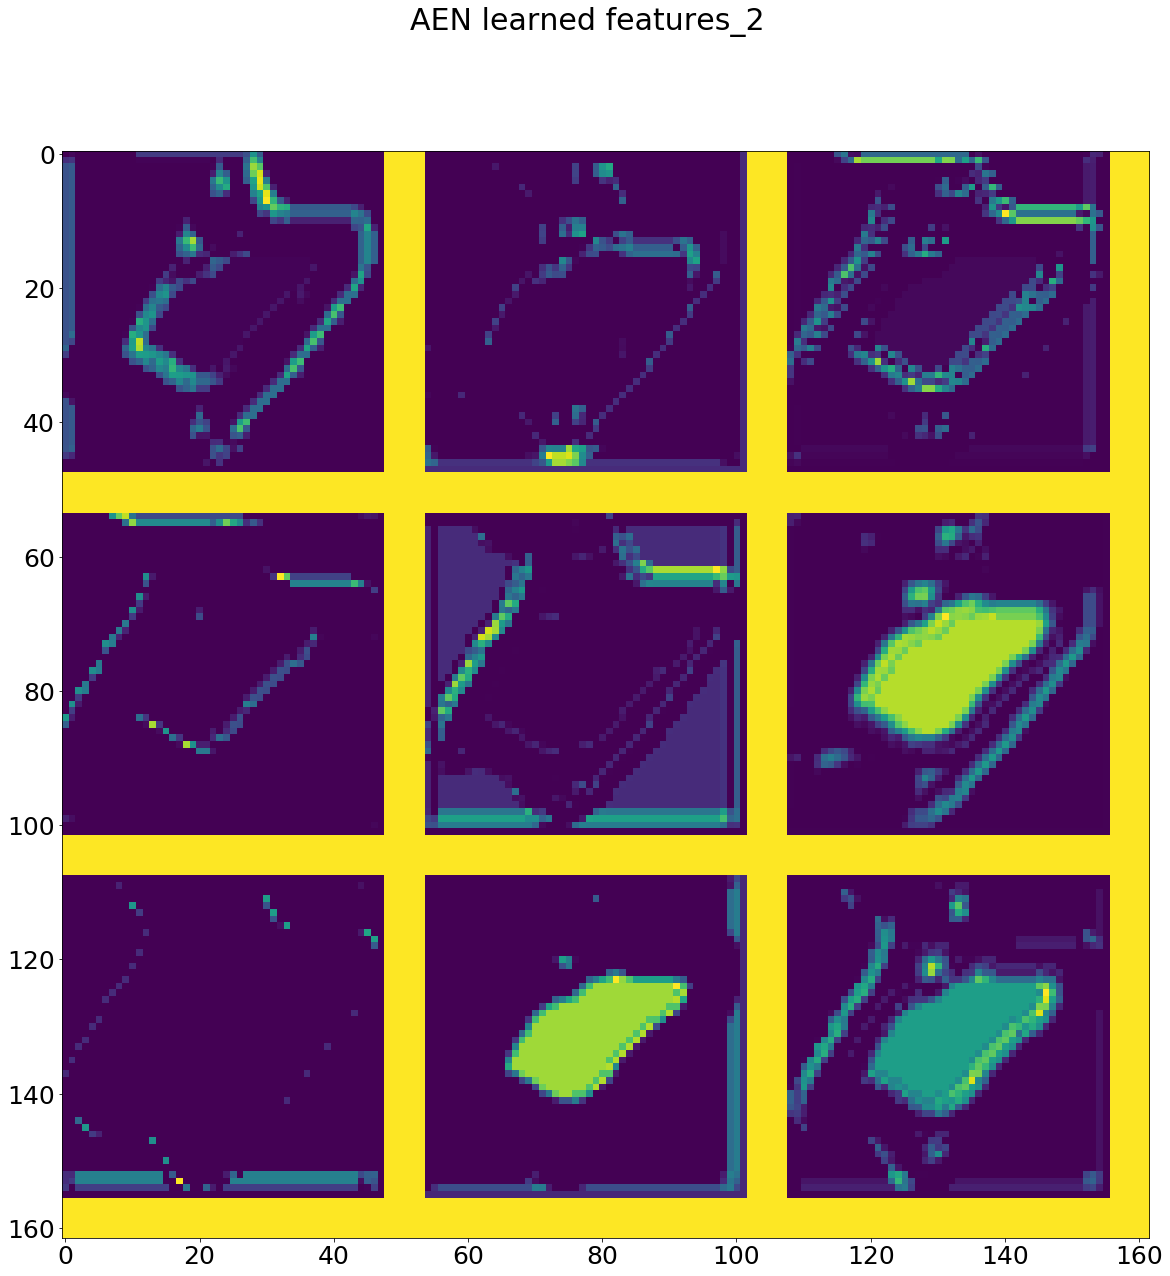

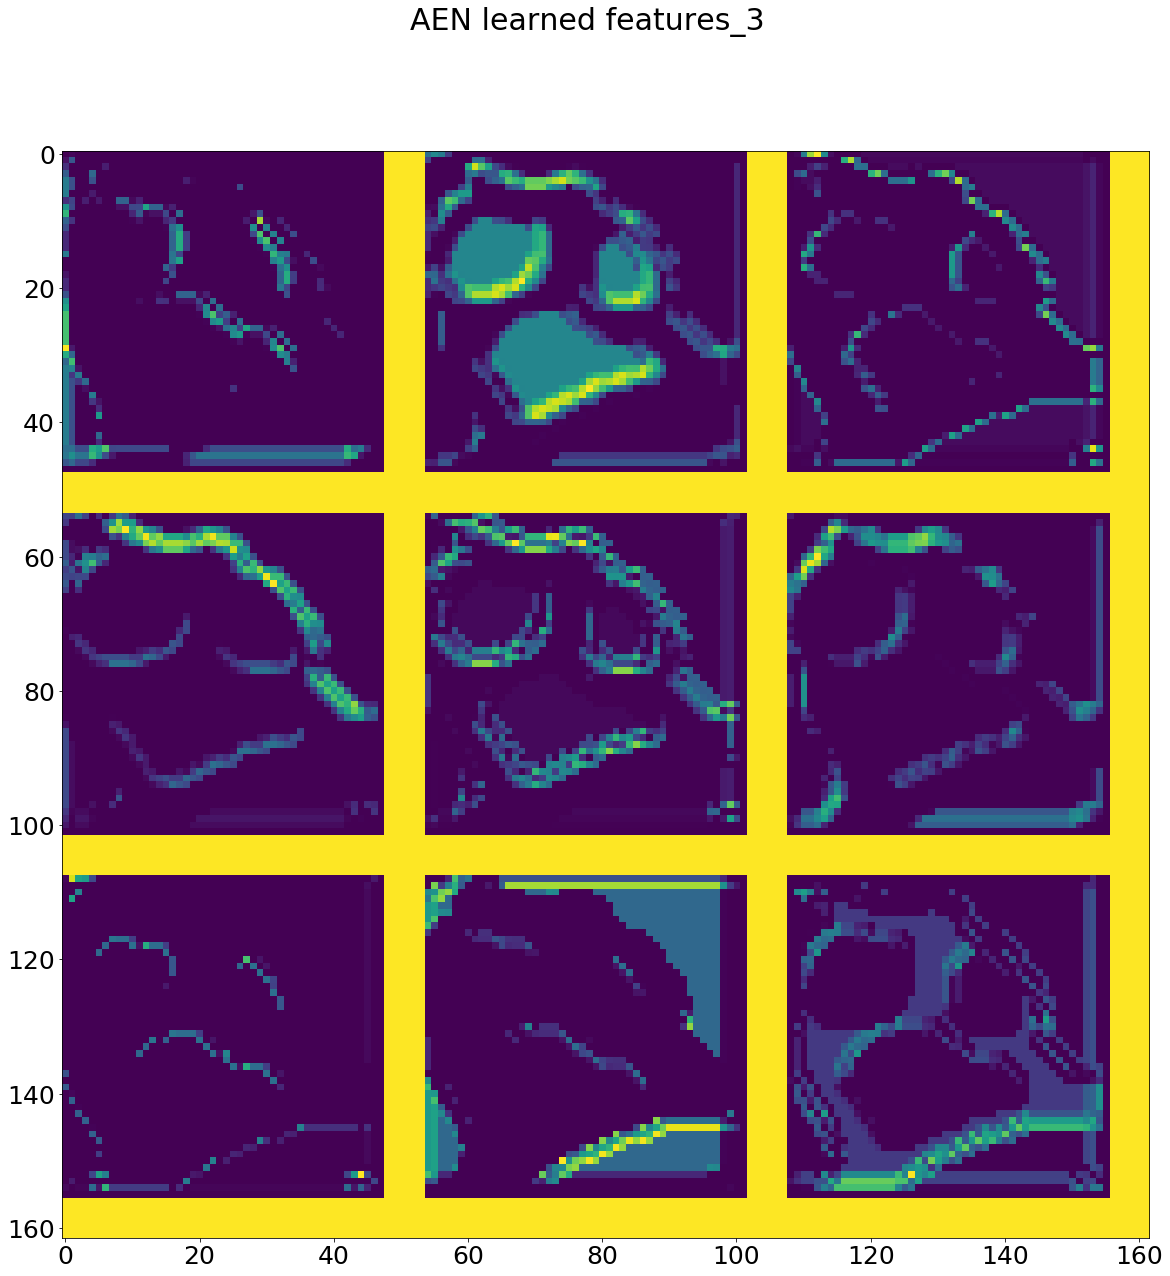

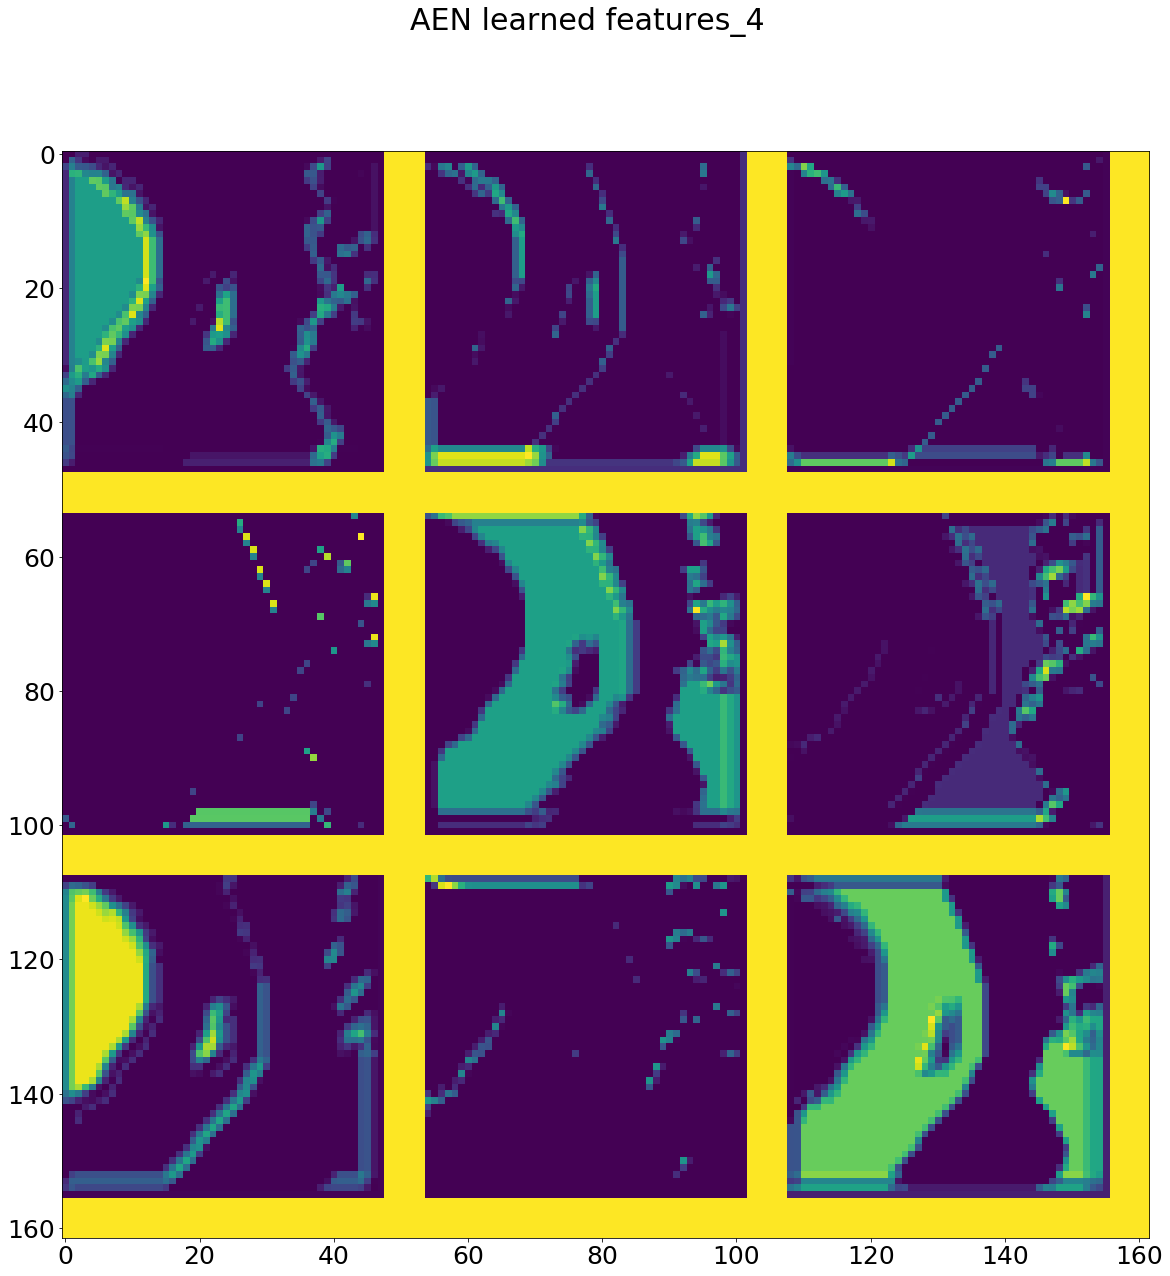

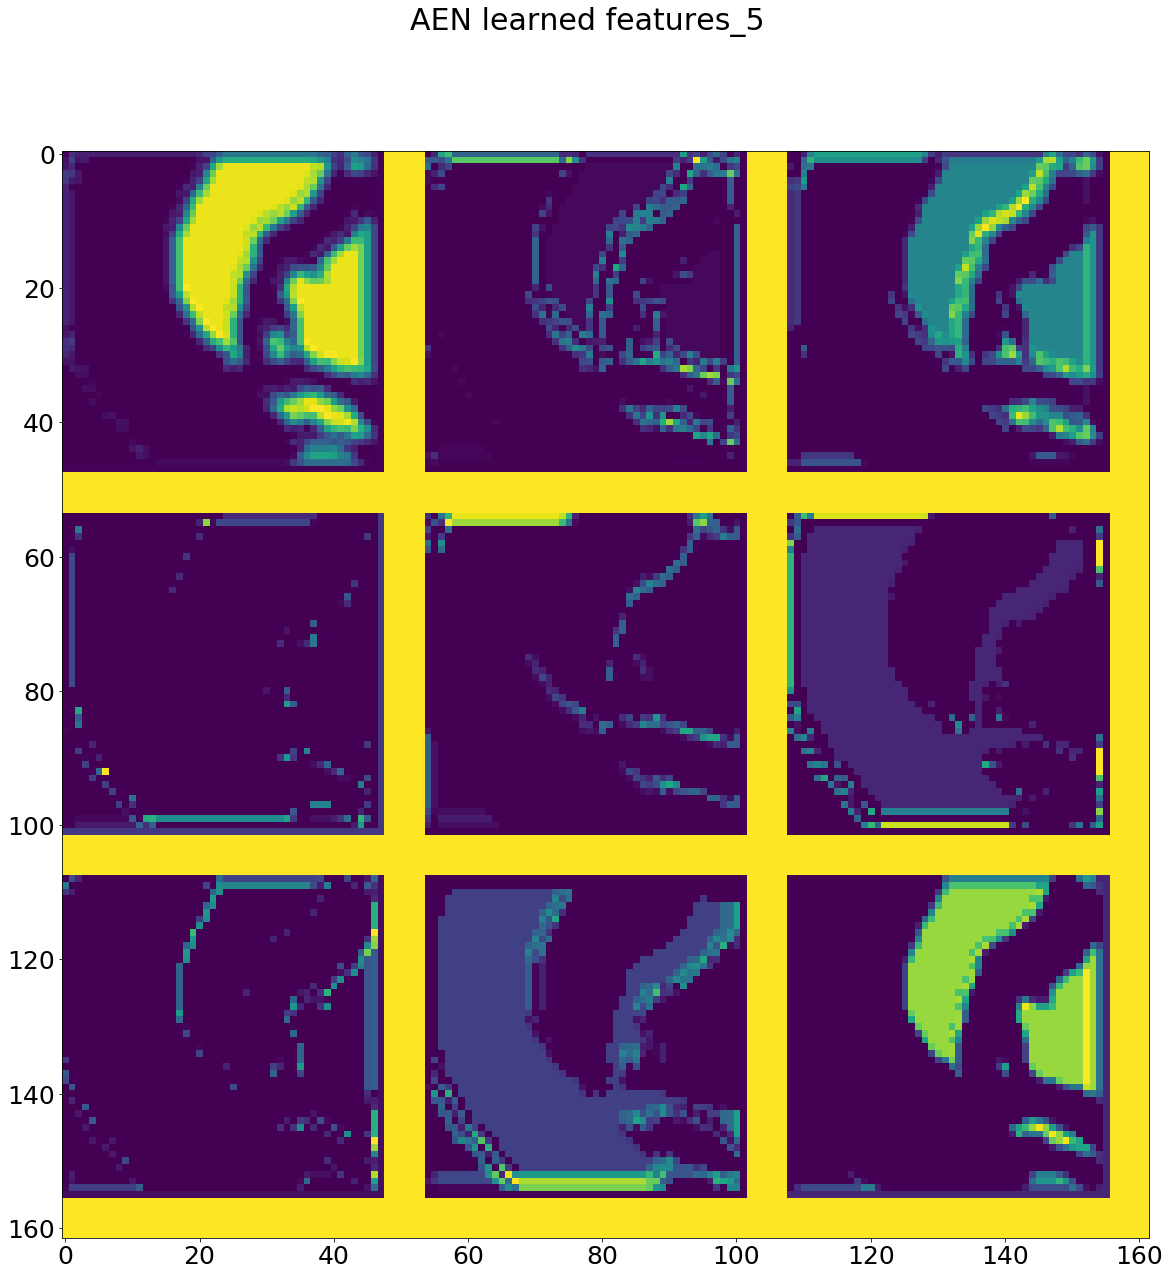

In [5]:




# MAIN CONFIG FLAG, False if new training
justDraw=True


draw_encoded_loc=r'../test_data/encoded_maps_vis'



# ---------------------------------------------------------
# ---------------------------------------------------------
# ---------------------------------------------------------
# ---------------------------------------------------------
# ---------------------------------------------------------
# ---------------------------------------------------------



model_loc=r'../test_data/weights_autoenc_dvov.hdf5'


img1 = cv2.imread(r'../test_data/interim_used/sp13909-img04-interim.tif', 0)
img2=cv2.imread(r'../test_data/Consensus corrected/sp13909-img04-corrected.tif',0)
print(img1.shape,img2.shape)


import matplotlib as mp
mp.rcParams.update({'font.size' :25,'lines.linewidth':3,
                    'savefig.bbox':'tight','axes.labelsize':35})


if justDraw:
    model=load_model(model_loc,custom_objects={'tf':tf})
    print(model.layers[0].input_shape)
    mod_name=model_loc[model_loc.index('weights_autoenc_'):]
    
    if not os.path.exists(draw_encoded_loc): os.makedirs(draw_encoded_loc)

    patchs=[]

    for img in [img1,img2]:
        patchs.append( img[834 - 22:834 + 23, 676 - 22:676 + 23])

        xcor, ycor = 1352, 922
        patchs.append(img[xcor - 22:xcor + 23, ycor - 22:ycor + 23])
        xcor, ycor = 1043, 871
        patchs.append(img[xcor - 22:xcor + 23, ycor - 22:ycor + 23])
        xcor, ycor = 1180, 1192
        patchs.append(img[xcor - 22:xcor + 23, ycor - 22:ycor + 23])
        xcor, ycor = 1458, 1134
        patchs.append(img[xcor - 22:xcor + 23, ycor - 22:ycor + 23])
        xcor, ycor = 1465, 934
        patchs.append(img[xcor - 22:xcor + 23, ycor - 22:ycor + 23])


    patchs=np.array(patchs)


    real_vals = make_split_map(patchs[:6],dopad=True)
    real_vals2=make_split_map(patchs[6:],dopad=True,split_map=[1,2,3])
    patches = np.zeros((2, 6, 48, 48, 3), dtype=np.uint8)
    patches[0,:]=real_vals
    patches[1,:]=real_vals2
    
    draw_someoutput(np.argmax(patches[0],axis=-1)
            ,draw_encoded_loc,chosen_cmap='gray',
            draw_suffix='autoenc_inputs'\
                .format(),doShow=True)
    plt.suptitle('AEN inputs')
    
    for iii in range(6):
        draw_autoenc_smaller(model,draw_encoded_loc,
                             patches
                             ,suff=mod_name+'__',showNum=iii)
        plt.suptitle('AEN learned features_{}'.format(iii))

#    draw_autoenc(model, img_w, img_h, draw_loc, val_lmdb)
    sys.exit('Im am done with everything!!')






## New training of AEN Network

This next block computes:

1. Obtaining the AEN neural network architecture;
2. Setup of the needed Data Bases;
3. Actually training the AEN.





In [ ]:
if not justDraw:
    model = get_autoencoded(img_w, img_h,)


    lmdbval_env=lmdb.open(val_lmdb)
    lmdbval_txn=lmdbval_env.begin()

    lmdbtrain_env=lmdb.open(train_lmdb)
    lmdbtrain_txn=lmdbtrain_env.begin()
    train_size=lmdbtrain_env.stat()['entries']
    val_size=8lmdbval_env.stat()['entries']
    

    start_t=time.time()



    # DISABLED HISTORY LOGGING CODE
    # oneI=iterate_indef(lmdbval_txn, batch_size, img_w * 2, img_h, two_patch_instance=True,
    #               do_continuous=True, split_map=split_patches,do_single_patch=do_single_map)
    # raw_patches=[next(oneI) for ind in range(5)]
    # val_data_x,val_data_y=np.concatenate([i[0] for i in raw_patches]), \
    #                       np.concatenate([i[1] for i in raw_patches])
    # oneI=None
    # log_losses.val_data=val_data_x,val_data_y




    history_mod=model.fit_generator(
        iterate_indef(lmdbtrain_txn,batch_size,img_w*2,img_h,
                      do_continuous=True,split_map=split_patches,
                      do_single_patch=do_single_map,two_patch_instance=True,),
                samples_per_epoch=train_size-train_size%batch_size,
                        nb_epoch=epoch_count,

              verbose=1,
            callbacks=all_calls,
            validation_data= \
            iterate_indef(lmdbval_txn, batch_size, img_w*2, img_h,two_patch_instance=True,
                          do_single_patch=do_single_map,do_continuous=True,split_map=split_patches),
            nb_val_samples=val_size-val_size%batch_size )


    lmdbtrain_env.close()

## Possibly Validate AEN

+ This last code block can validate the **already trained** AEN network

In [1]:


score = model.evaluate_generator(
    iterate_indef(lmdbval_txn, batch_size, img_w,
                  img_h, do_continuous=True),
        val_samples=val_size-val_size%batch_size, )

print('Test score:', score[0])
print('Test accuracy:', score[1])


lmdbval_env.close()

NameError: name 'lmdbval_env' is not defined